# Probabilistic PCA

Probabilistic principal components analysis (PCA) is a
dimensionality reduction technique that
analyzes data via a lower dimensional latent space
(Tipping & Bishop, 1999). It is often
used when there are missing values in the data or for multidimensional
scaling.

We demonstrate with an example in Edward. A webpage version is available at
http://edwardlib.org/tutorials/probabilistic-pca.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

## Data

We use simulated data. We'll talk about the individual variables and
what they stand for in the next section. For this example, each data
point is 2-dimensional, $\mathbf{x}_n\in\mathbb{R}^2$.

In [2]:
def build_toy_dataset(N, D, K, sigma=1):
  x_train = np.zeros((D, N))
  w = np.random.normal(0.0, 2.0, size=(D, K))
  z = np.random.normal(0.0, 1.0, size=(K, N))
  mean = np.dot(w, z)
  for d in range(D):
    for n in range(N):
      x_train[d, n] = np.random.normal(mean[d, n], sigma)

  print("True principal axes:")
  print(w)
  return x_train

ed.set_seed(142)

N = 5000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

x_train = build_toy_dataset(N, D, K)

True principal axes:
[[0.25947927]
 [1.80472372]]


We visualize the data set.

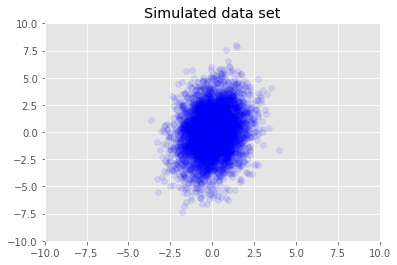

In [3]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

## Model

Consider a data set $\mathbf{X} = \{\mathbf{x}_n\}$ of $N$ data
points, where each data point is $D$-dimensional, $\mathbf{x}_n \in
\mathbb{R}^D$. We aim to represent each $\mathbf{x}_n$ under a latent
variable $\mathbf{z}_n \in \mathbb{R}^K$ with lower dimension, $K <
D$. The set of principal axes $\mathbf{W}$ relates the latent variables to
the data.

Specifically, we assume that each latent variable is normally distributed,

\begin{equation*}
\mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}).
\end{equation*}

The corresponding data point is generated via a projection,

\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}),
\end{equation*}

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as
the principal axes. In probabilistic PCA, we are typically interested in
estimating the principal axes $\mathbf{W}$ and the noise term
$\sigma^2$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the
latent variable, the distribution of each data point is

\begin{equation*}
\mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^Y + \sigma^2\mathbf{I}).
\end{equation*}

Classical PCA is the specific case of probabilistic PCA when the
covariance of the noise becomes infinitesimally small, $\sigma^2 \to 0$.

We set up our model below. In our analysis, we fix $\sigma=2.0$, and
instead of point estimating $\mathbf{W}$ as a model parameter, we
place a prior over it in order to infer a distribution over principal
axes.

In [4]:
noise_std = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
w = Normal(loc=tf.zeros([D, K]), scale=2.0 * tf.ones([D, K]))
z = Normal(loc=tf.zeros([N, K]), scale=tf.ones([N, K]))
x = Normal(loc=tf.matmul(w, z, transpose_b=True), scale=tf.ones([D, N]) * noise_std)

## Inference

The posterior distribution over the principal axes $\mathbf{W}$ cannot
be analytically determined. Below, we set up our inference variables
and then run a chosen algorithm to infer $\mathbf{W}$. Below we use
variational inference to minimize the $\text{KL}(q\|p)$ divergence
measure.

In [5]:
qw = Normal(loc=tf.get_variable("qw/loc", [D, K]),
            scale=tf.nn.softplus(tf.get_variable("qw/scale", [D, K])))
qz = Normal(loc=tf.get_variable("qz/loc", [N, K]),
            scale=tf.nn.softplus(tf.get_variable("qz/scale", [N, K])))

inference = ed.KLqp({w: qw, z: qz}, data={x: x_train})
inference.run(n_iter=500, n_print=100, n_samples=10)

/work/modules/Ubuntu/16.04/amd64/common/courses/CS-E4820-advanced-probabilistic-methods/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 17817.986


## Criticism

To check our inferences, we first inspect the model's learned
principal axes.

In [6]:
sess = ed.get_session()
print("Inferred principal axes:")
print(sess.run(qw.mean()))

Inferred principal axes:
[[-0.23725247]
 [-1.7679653 ]]


The model has recovered the true principal axes up to finite data and
also up to identifiability (there's a symmetry in the
parameterization).

Another way to criticize the model is to visualize the observed data
against data generated from our fitted model. The blue dots represent
the original data, while the red is the inferred.

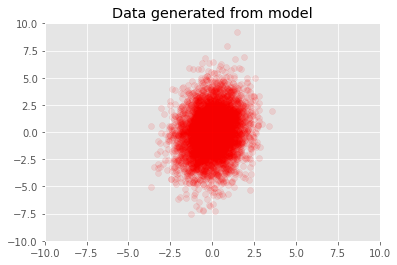

In [7]:
# Build and then generate data from the posterior predictive distribution.
x_post = ed.copy(x, {w: qw, z: qz})
x_gen = sess.run(x_post)

plt.scatter(x_gen[0, :], x_gen[1, :], color='red', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Data generated from model")
plt.show()

The generated data looks close to the true data.

## Acknowledgements

We thank Mayank Agrawal for writing the initial version of this
tutorial.

In [8]:
noise_std.eval()

0.99644876